# Setup

In [1]:
# ResNet reference: https://www.kaggle.com/aadhavvignesh/pytorch-garbage-classification-95-accuracy
# PyTorch data preprocessing reference: https://www.kaggle.com/altanai/garbage-segrigation-on-pytorch-95-accuracy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  

#Set the run time to be GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [2]:
from google.colab import drive
drive.mount("/content/drive")
# data_dir = "/content/drive/My Drive/garbage_data/Garbage_classification/Garbage_classification"
data_dir = "/content/drive/My Drive/garbage_data/Garbage_classification/Garbage_classification"

classes = os.listdir(data_dir)
print(classes)

Mounted at /content/drive
['trash', 'glass', 'cardboard', 'paper', 'metal', 'plastic']


In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# Transform the image to be size 28 * 28
transformations = transforms.Compose([ transforms.Resize((256, 256)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = ImageFolder(data_dir, transform = transformations)

dataset

Dataset ImageFolder
    Number of datapoints: 2527
    Root location: /content/drive/My Drive/garbage_data/Garbage_classification/Garbage_classification
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [4]:
# #Data Augmentation
# transformations = transforms.Compose([ transforms.Resize((256, 256)),
#      transforms.ToTensor(),
#      transforms.RandomVerticalFlip(p=0.5),
#      transforms.RandomHorizontalFlip(p=0.5),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# augmented_dataset = ImageFolder(data_dir, transform = transformations)
# increased_dataset = torch.utils.data.ConcatDataset([dataset,augmented_dataset])
# increased_dataset
# dataset = increased_dataset

In [5]:
#A helper function to see image and its corresponding label
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: cardboard (Class No: 0)


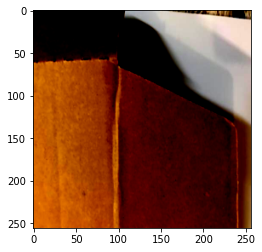

In [6]:
img, label = dataset[17]
show_sample(img, label)

# Loading Data

In [7]:
# Set Random Seed
random_seed = 42
torch.manual_seed(random_seed)

In [8]:
from torch.utils import data
# train_ds, val_ds = data.random_split(dataset, [1593, 176+758])
# len(train_ds), len(val_ds)
train_ds, val_ds, test_ds = data.random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

In [9]:
train_ds

In [10]:
val_ds

In [11]:
# test_ds

In [12]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [13]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 2, pin_memory = True)
test_dl = DataLoader(test_ds,batch_size*2,num_workers=2,pin_memory=True)

In [14]:
#Helper function to visualize batches
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

In [15]:
# show_batch(train_dl)

In [16]:
# show_batch(val_dl)

# VGG16


Reference1: https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce

Reference2: https://debuggercafe.com/transfer-learning-with-pytorch/

## Loading Model

In [34]:
from torchvision import models
model = models.vgg16_bn(pretrained=True)

In [35]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

## Freeze weights & Update classifier

In [36]:
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

In [37]:
import torch.nn as nn
# Add on classifier
# model.classifier[6] = nn.Sequential(
#                       nn.Linear(4096, 3000), 
#                       nn.ReLU(), 
#                       nn.Dropout(0.3),
#                       nn.Linear(3000, 2048), 
#                       nn.ReLU(), 
#                       nn.Dropout(0.3),
#                       nn.Linear(2048, 1024), 
#                       nn.ReLU(), 
#                       nn.Dropout(0.3),
#                       nn.Linear(1024, 256), 
#                       nn.ReLU(), 
#                       nn.Dropout(0.3),
#                       nn.Linear(256, len(classes)),                   
#                       nn.LogSoftmax(dim=1))
#Update classifier
num_ftrs = 25088
model.classifier = nn.Sequential(
                      nn.Linear(num_ftrs, 1024), 
                      nn.ReLU(), 
                      nn.Linear(1024, 256),
                      nn.ReLU(),
                      nn.Dropout(0.2), 
                      nn.Linear(256, len(classes)),
                      # nn.Linear(num_ftrs, len(classes)),
                      nn.LogSoftmax(dim=1))

In [38]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [39]:
# from torchsummary import summary
# summary(model, input_size=(3, 224, 224))

## Training

In [40]:
import torch
torch.cuda.empty_cache()

In [41]:
model = model.cuda()



*   Feature Extraction



In [42]:
from torch import optim
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [43]:
def get_validaion_loss(model):
  loss = 0
  total = 0 
  with torch.no_grad():
    for data in val_dl:
        images, labels = data
        total += labels.size(0)
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss += criterion(outputs, labels).item()
  return loss / total
        # _, predicted = torch.max(outputs.data, 1)
        # total += labels.size(0)
        # correct += (predicted == labels.cuda()).sum().item()

In [44]:
training_loss = []
validaion_loss = []
for epoch in range(8):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # print(loss.item())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 0:    # print every epoch
          print('Epoch: %d loss: %.3f' % (epoch + 1, running_loss/50))
          # print("val:", validaion_loss)
          training_loss.append(running_loss/50)
          validaion_loss.append(get_validaion_loss(model))
          print("val:", get_validaion_loss(model))
          running_loss = 0.0

print('Finished Training')
torch.save(model, 'baseline_model.pth')

Epoch: 1 loss: 0.036
val: 0.029056134549054233
Epoch: 2 loss: 0.005
val: 0.010337136008522728
Epoch: 3 loss: 0.001
val: 0.011423863470554352
Epoch: 4 loss: 0.001
val: 0.011705419217998331
Epoch: 5 loss: 0.000
val: 0.011338974941860546
Epoch: 6 loss: 0.000
val: 0.016593451188369232
Epoch: 7 loss: 0.000
val: 0.014958070760423487
Epoch: 8 loss: 0.000
val: 0.011517743834040382
Finished Training


In [45]:
# print(training_loss, validaion_loss)

Text(0.5, 1.0, 'VGG16 + SVM')

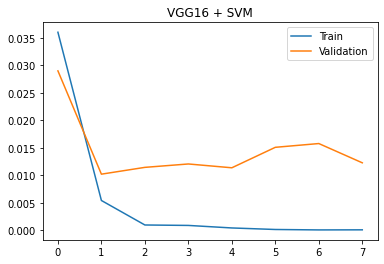

In [46]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(training_loss)
plt.plot(validaion_loss)
plt.legend(['Train', 'Validation'])
plt.title('VGG16 + SVM')

## Test

In [47]:
with torch.no_grad():
    i = 0
    for data in train_dl:
        images, labels = data
        outputs = model(images.cuda()).cpu().numpy()
        if i == 0:
          train_feat = outputs
          train_label = labels.numpy()
          i = i+1
        else:
          train_feat = np.concatenate((train_feat,outputs),axis=0)
          train_label = np.concatenate((train_label,labels.numpy()),axis=0)
    print(train_feat.shape)
    print(train_label.shape)

(1593, 6)
(1593,)


In [48]:
with torch.no_grad():
    i = 0
    for data in val_dl:
        images, labels = data
        outputs = model(images.cuda()).cpu().numpy()
        if i == 0:
          val_feat = outputs
          val_label = labels.numpy()
          i = i+1
        else:
          val_feat = np.concatenate((val_feat,outputs),axis=0)
          val_label = np.concatenate((val_label,labels.numpy()),axis=0)
    print(val_feat.shape)
    print(val_label.shape)

(176, 6)
(176,)


In [49]:
with torch.no_grad():
    i = 0
    for data in test_dl:
        images, labels = data
        outputs = model(images.cuda()).cpu().numpy()
        if i == 0:
          test_feat = outputs
          test_label = labels.numpy()
          i = i+1
        else:
          test_feat = np.concatenate((test_feat,outputs),axis=0)
          test_label = np.concatenate((test_label,labels.numpy()),axis=0)
    print(test_feat.shape)
    print(test_label.shape)

(758, 6)
(758,)




*   SVM Training



In [50]:
from sklearn import svm
clf = svm.SVC(C=1, kernel='poly',verbose = True, degree=1)  # linear kernel
# clf = svm.SVC(C=0.5, kernel='poly',verbose = True, degree=3)
clf.fit(train_feat, train_label)

[LibSVM]

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=1, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)

In [51]:
from sklearn.metrics import f1_score

In [52]:
print('svm training accuracy:')
print(clf.score(train_feat, train_label))
print('svm training f1:')
print(f1_score(clf.predict(train_feat), train_label, average='weighted'))

svm training accuracy:
0.9981167608286252
svm training f1:
0.9981168420655501


In [53]:
print('svm validation accuracy:')
print(clf.score(val_feat, val_label))
print('svm validation f1:')
print(f1_score(clf.predict(val_feat), val_label, average='weighted'))

svm validation accuracy:
0.8011363636363636
svm validation f1:
0.8034719531473865


In [54]:
print('svm testing accuracy:')
print(clf.score(test_feat, test_label))
print('svm testing f1:')
print(f1_score(clf.predict(test_feat), test_label, average='weighted'))

svm testing accuracy:
0.8324538258575198
svm testing f1:
0.8344835249845124
